In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, Binarizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

data = pd.read_csv('iris.csv')
print("Размер датасета:", data.shape)
data.head()

Размер датасета: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Выбран датасет Iris, содержащий сведения о параметрах трёх видов ирисов: Iris setosa, Iris versicolor и Iris virginica.
Каждая запись содержит числовые признаки: длину и ширину лепестков и чашелистиков, а также категориальный признак — название вида цветка.

In [72]:
base = data.drop(columns=['Id'], errors='ignore')
print("Пропуски до обработки:")
print(base.isnull().sum())
num_cols = base.select_dtypes(include=np.number).columns
for col in num_cols:
    base[col] = base[col].fillna(base[col].median())

cat_cols = base.select_dtypes(include='object').columns
for col in cat_cols:
    base[col] = base[col].fillna(base[col].mode()[0])

print("\nПервые 5 строк очищенных данных:")
print(base.head())

Пропуски до обработки:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Первые 5 строк очищенных данных:
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


На этом этапе из данных удалён неинформативный столбец Id и выполнена очистка пропусков:
числовые признаки заполнены медианой, категориальные — модой.

In [73]:
y = base['species']
X = base.drop(columns=['species'])

num_cols = X.columns.tolist()
cat_cols = []

preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='drop'
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Размер обучающей выборки:", X_train_raw.shape)
print("Размер тестовой выборки:", X_test_raw.shape)


Размер обучающей выборки: (120, 4)
Размер тестовой выборки: (30, 4)


Выполнено разделение данных на обучающую (80 %) и тестовую (20 %) выборки с сохранением пропорций классов.
Целевая переменная — species (вид ириса), признаки — числовые характеристики цветков.
Перед обучением предусмотрена стандартизация числовых признаков с помощью StandardScaler.

In [74]:
def evaluate_and_plot(model_name, y_test, y_pred, y_proba=None, classes=None):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    if y_proba is not None and len(np.unique(y_test)) > 2:
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import RocCurveDisplay

        y_bin = label_binarize(y_test, classes=classes)
        n_classes = y_bin.shape[1]

        plt.figure(figsize=(7, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            auc_val = roc_auc_score(y_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc_val:.3f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC-кривые: {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

    metrics = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    plt.figure()
    plt.bar(list(metrics.keys()), list(metrics.values()), color=['#5A9', '#69C', '#E96', '#D55'])
    plt.ylim(0, 1)
    plt.title(f'Метрики: {model_name}')
    plt.ylabel('Значение')
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    return metrics

Определена функция evaluate_and_plot, которая:
1.вычисляет метрики accuracy, precision, recall, f1 (макро-усреднение);
2.при наличии вероятностей класса и мультиклассовой постановке строит ROC-кривые по схеме One-vs-Rest и выводит AUC для каждого класса;
3.визуализирует метрики в виде столбчатой диаграммы;


=== GaussianNB ===


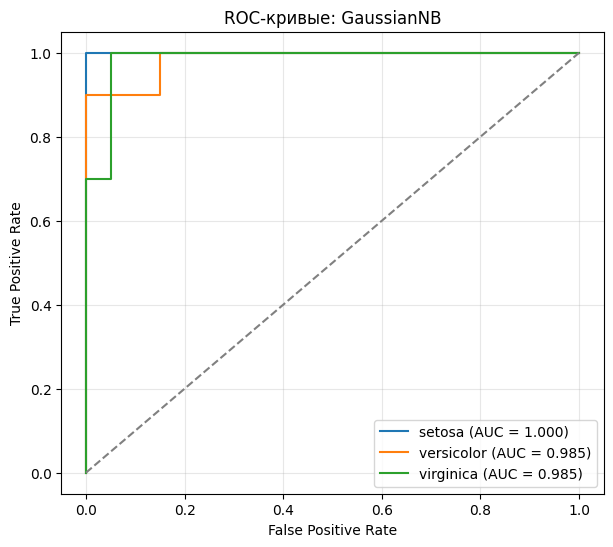

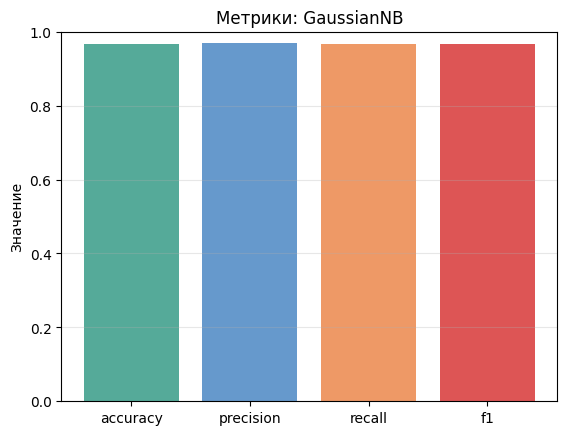


=== MultinomialNB ===


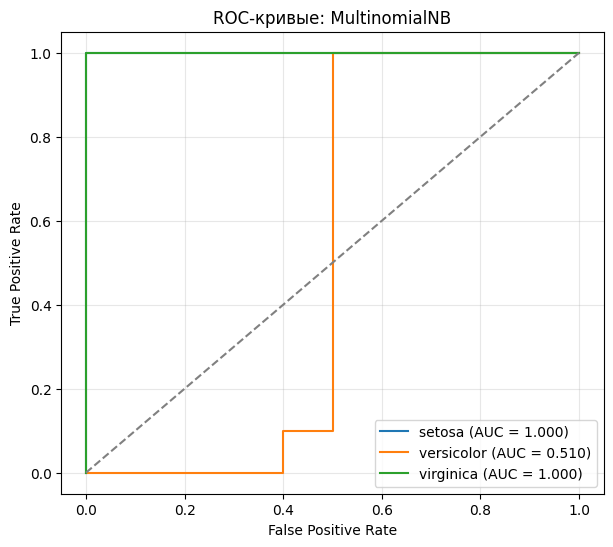

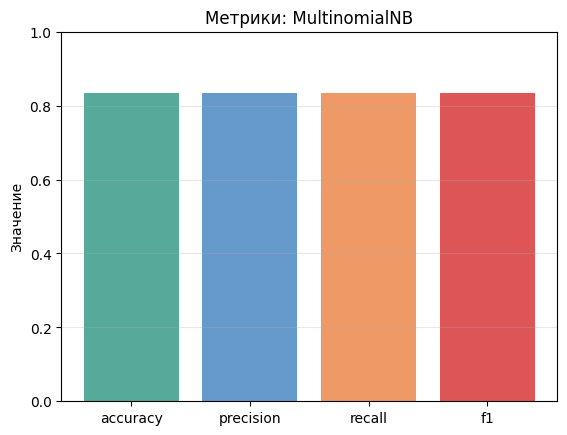


=== ComplementNB ===


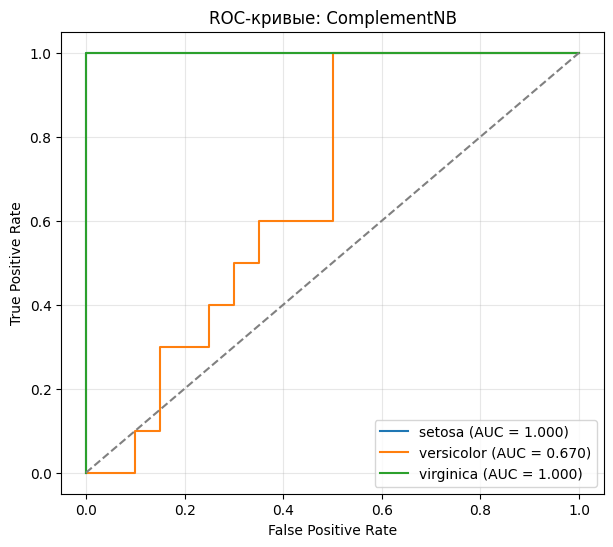

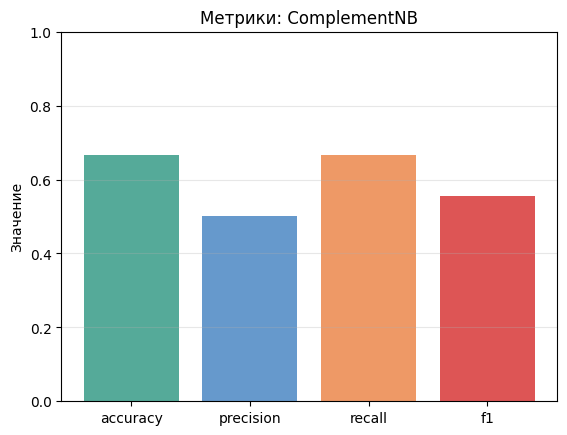


=== BernoulliNB ===


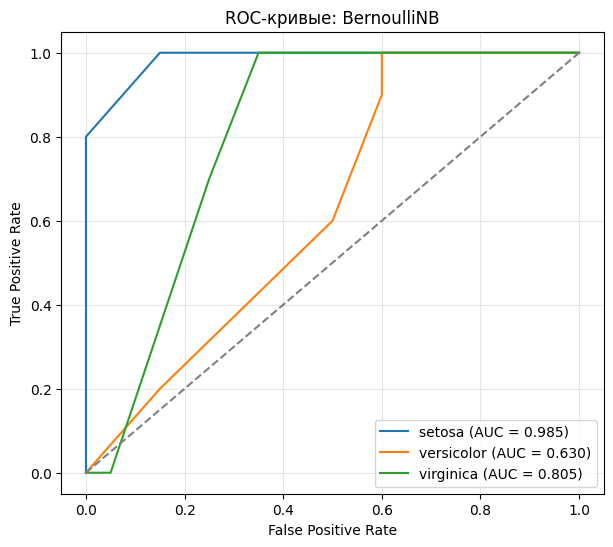

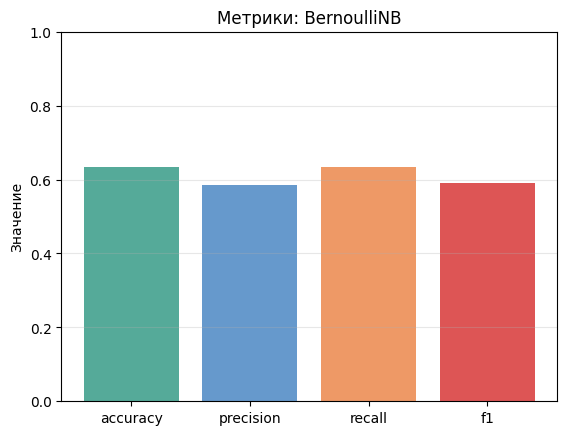

In [75]:
num_cols = X_train_raw.columns.tolist()
cat_cols = []

preprocess_std = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)
preprocess_minmax = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols)
    ],
    remainder='drop'
)

preprocess_bernoulli = Pipeline(steps=[
    ('ct', preprocess_minmax),
    ('bin', Binarizer(threshold=0.5))
])

pipe_gnb = Pipeline([
    ('prep', preprocess_std),
    ('clf', GaussianNB())
])

pipe_mnb = Pipeline([
    ('prep', preprocess_minmax),
    ('clf', MultinomialNB())
])

pipe_cnb = Pipeline([
    ('prep', preprocess_minmax),
    ('clf', ComplementNB())
])

pipe_bnb = Pipeline([
    ('prep', preprocess_bernoulli),
    ('clf', BernoulliNB())
])

metrics_nb = {}

for name, pipe in [
    ('GaussianNB', pipe_gnb),
    ('MultinomialNB', pipe_mnb),
    ('ComplementNB', pipe_cnb),
    ('BernoulliNB', pipe_bnb),
]:
    print(f'\n=== {name} ===')
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test_raw)
    except Exception:
        pass

    metrics_nb[name] = evaluate_and_plot(
        name, y_test, y_pred, y_proba, classes=pipe.named_steps['clf'].classes_
    )

Собраны четыре конвейера Наивного Байеса с подходящим препроцессингом под каждый алгоритм:
StandardScaler для GaussianNB; MinMaxScaler для Multinomial/ComplementNB (неотрицательные признаки); MinMax + бинаризация для BernoulliNB.
Все модели обучаются на одинаковом train-наборе, затем оцениваются по accuracy, precision, recall, F1; при наличии predict_proba строятся мультиклассовые ROC-кривые.

GaussianNB
Модель показала почти идеальное качество: AUC для всех классов близок к 1.0, все метрики (accuracy, precision, recall, f1) ≈ 0.97.
ROC-кривые проходят у верхнего левого угла — отличное разделение классов.

MultinomialNB
Хорошо различает setosa и virginica (AUC = 1.0), но хуже versicolor (AUC ≈ 0.5).
Средние метрики около 0.83 — результат удовлетворительный, но ниже GaussianNB.

ComplementNB
Для versicolor качество низкое (AUC ≈ 0.67), общие метрики — accuracy ≈ 0.67, f1 ≈ 0.56.
Модель теряет информацию при комплементарных вычислениях.

BernoulliNB
AUC = 0.63–0.98, метрики ≈ 0.6.
Бинаризация признаков ухудшила качество классификации.

Вывод:
Лучшие результаты показала модель GaussianNB, остальные варианты уступают из-за ограничений по типу входных данных.


=== Decision Tree ===


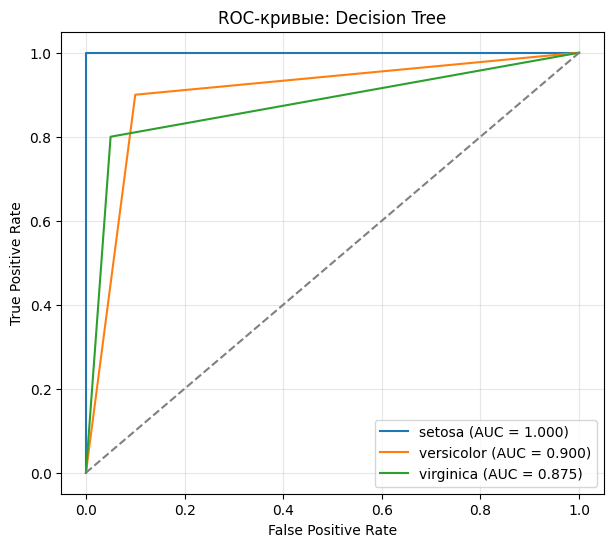

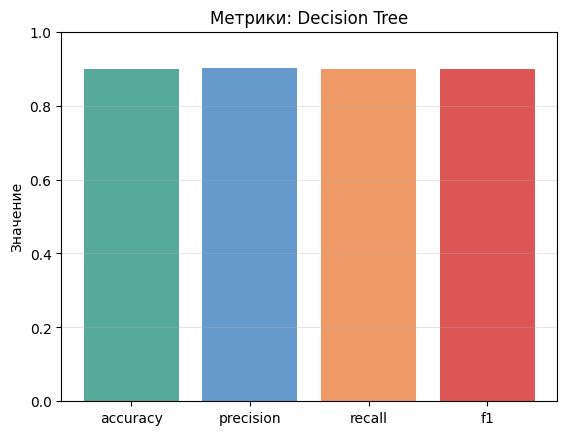

In [76]:
preprocess_dt = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='drop'
)
pipe_dt = Pipeline([
    ('prep', preprocess_dt),
    ('clf', DecisionTreeClassifier(random_state=42))
])

print("\n=== Decision Tree ===")
pipe_dt.fit(X_train_raw, y_train)

y_pred_dt = pipe_dt.predict(X_test_raw)

y_proba_dt = pipe_dt.predict_proba(X_test_raw)

metrics_dt = evaluate_and_plot(
    "Decision Tree",
    y_test,
    y_pred_dt,
    y_proba=y_proba_dt,
    classes=pipe_dt.named_steps['clf'].classes_
)

Построен конвейер для Decision Tree: стандартизация признаков (для унификации) и обучение классификатора с фиксированным random_state=42. Получены предсказания меток и вероятностей, после чего метрики (accuracy, precision, recall, f1) и ROC-кривые рассчитаны общей функцией evaluate_and_plot.

ROC-кривые:
Модель дерева решений показала хорошее качество классификации.
Для класса setosa AUC = 1.000 — распознаётся идеально.
Для versicolor и virginica значения AUC составляют 0.900 и 0.875 соответственно, что говорит о высокой, но не максимальной способности модели различать эти классы.
ROC-кривые располагаются близко к левому верхнему углу, что подтверждает высокую точность.
Алгоритм Decision Tree показал высокие результаты и способен эффективно классифицировать виды ирисов, уступая лишь немного GaussianNB.


=== Linear Discriminant Analysis (LDA) ===


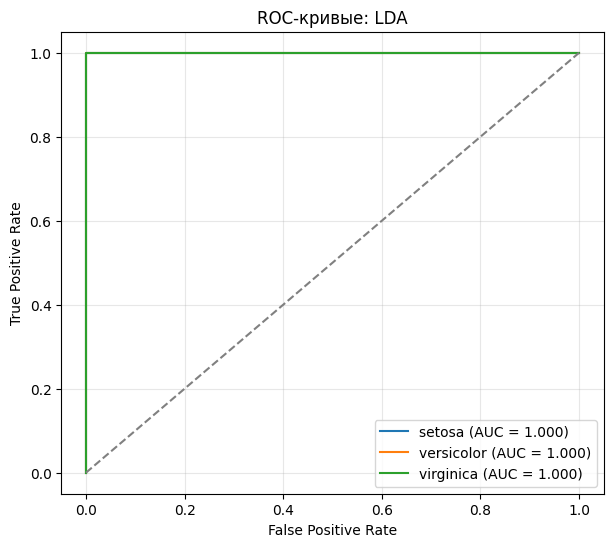

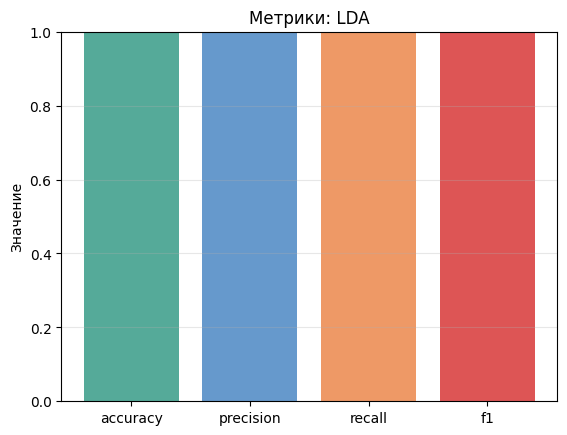

In [77]:
preprocess_lda = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

pipe_lda = Pipeline([
    ('prep', preprocess_lda),
    ('clf', LinearDiscriminantAnalysis())
])

print("\n=== Linear Discriminant Analysis (LDA) ===")
pipe_lda.fit(X_train_raw, y_train)

y_pred_lda = pipe_lda.predict(X_test_raw)

y_proba_lda = pipe_lda.predict_proba(X_test_raw)

metrics_lda = evaluate_and_plot(
    "LDA",
    y_test,
    y_pred_lda,
    y_proba=y_proba_lda,
    classes=pipe_lda.named_steps['clf'].classes_
)

Построен конвейер для Linear Discriminant Analysis (LDA), включающий стандартизацию признаков и обучение модели.
LDA строит линейные комбинации признаков для наилучшего разделения классов.
ROC-кривые:
Модель линейного дискриминантного анализа показала идеальное качество классификации.
Для всех трёх классов (setosa, versicolor, virginica) AUC = 1.000,
кривые проходят по верхнему и левому краям диаграммы — ошибок классификации нет.
Это говорит о полном разделении классов в пространстве признаков после применения LDA.


=== Support Vector Machines (SVM) ===


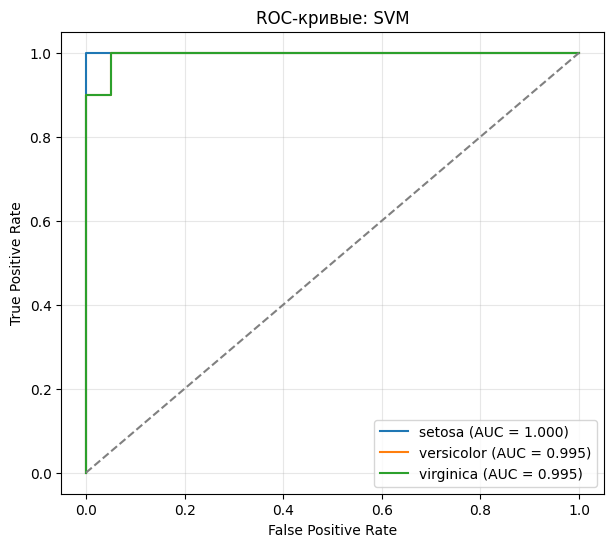

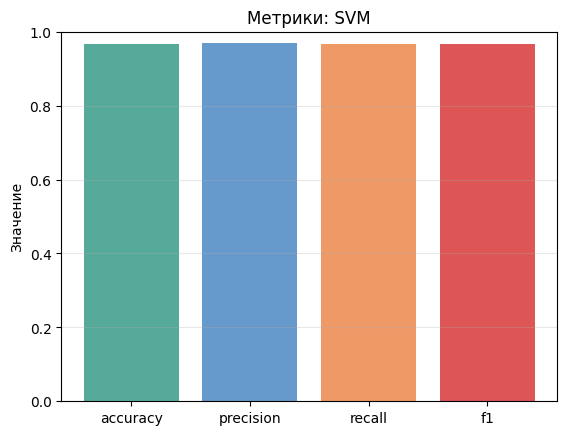

In [78]:
preprocess_svm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

pipe_svm = Pipeline([
    ('prep', preprocess_svm),
    ('clf', SVC(probability=True, random_state=42))
])

print("\n=== Support Vector Machines (SVM) ===")
pipe_svm.fit(X_train_raw, y_train)

y_pred_svm = pipe_svm.predict(X_test_raw)

y_proba_svm = pipe_svm.predict_proba(X_test_raw)

metrics_svm = evaluate_and_plot(
    "SVM",
    y_test,
    y_pred_svm,
    y_proba=y_proba_svm,
    classes=pipe_svm.named_steps['clf'].classes_
)

Построен конвейер для SVM (Support Vector Machines), включающий стандартизацию признаков и обучение классификатора с возможностью расчёта вероятностей классов (probability=True).
ROC-кривые:
Модель SVM продемонстрировала почти идеальное качество классификации.
Для класса setosa AUC = 1.000, для versicolor и virginica — 0.995.
Кривые проходят почти по границе верхнего левого угла, что свидетельствует о высокой чувствительности и специфичности алгоритма.


=== k-Nearest Neighbors (k-NN) ===


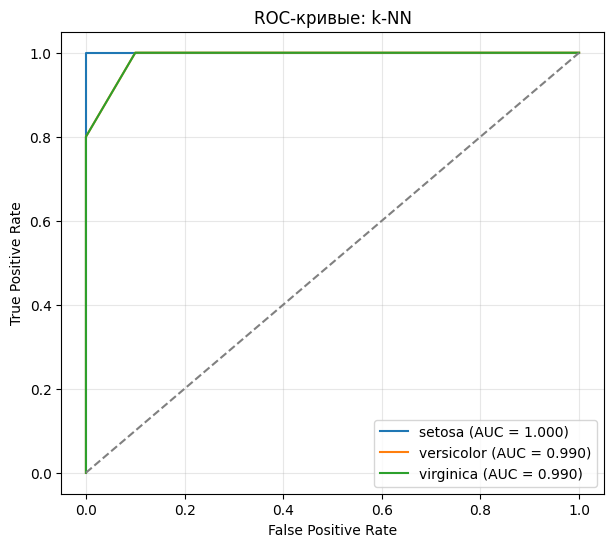

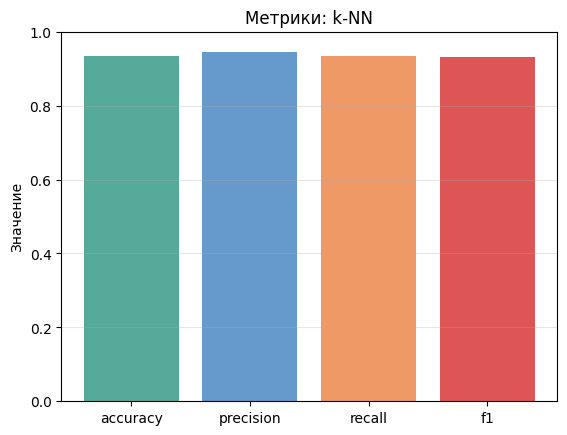

In [79]:
preprocess_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

pipe_knn = Pipeline([
    ('prep', preprocess_knn),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

print("\n=== k-Nearest Neighbors (k-NN) ===")
pipe_knn.fit(X_train_raw, y_train)

y_pred_knn = pipe_knn.predict(X_test_raw)

try:
    y_proba_knn = pipe_knn.predict_proba(X_test_raw)
except Exception:
    y_proba_knn = None

metrics_knn = evaluate_and_plot(
    "k-NN",
    y_test,
    y_pred_knn,
    y_proba=y_proba_knn,
    classes=pipe_knn.named_steps['clf'].classes_
)


Реализован конвейер для метода k ближайших соседей (k-NN) с числом соседей k=5.
Признаки предварительно стандартизированы, так как расстояния между объектами зависят от масштаба данных.
OC-кривые:
Метод k ближайших соседей показал высокую способность различать классы.
Для setosa значение AUC = 1.000, для versicolor и virginica — 0.990.
Кривые располагаются у верхнего левого угла, что говорит о почти идеальной классификации и низком уровне ошибок.

,accuracy,precision,recall,f1,AUC-ROC
model,,,,,
LDA,1.000,1.000,1.000,1.000,1.000
GaussianNB,0.967,0.970,0.967,0.967,0.990
SVM,0.967,0.970,0.967,0.967,0.997
k-NN,0.933,0.944,0.933,0.933,0.993
Decision Tree,0.900,0.902,0.900,0.900,0.925
MultinomialNB,0.833,0.835,0.833,0.833,0.837
BernoulliNB,0.633,0.584,0.633,0.591,0.807
ComplementNB,0.667,0.500,0.667,0.556,0.890


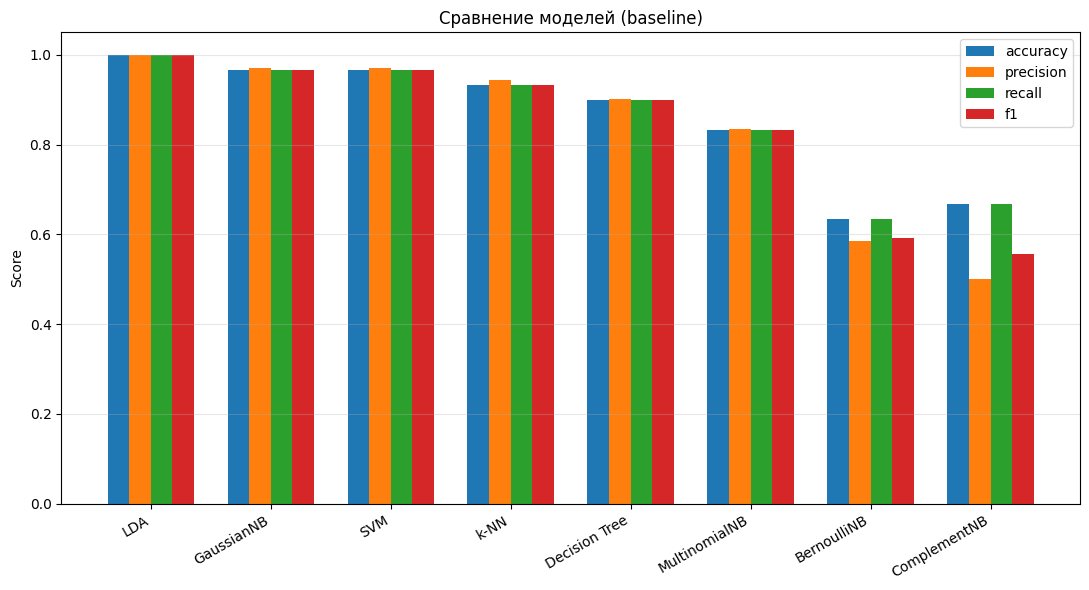

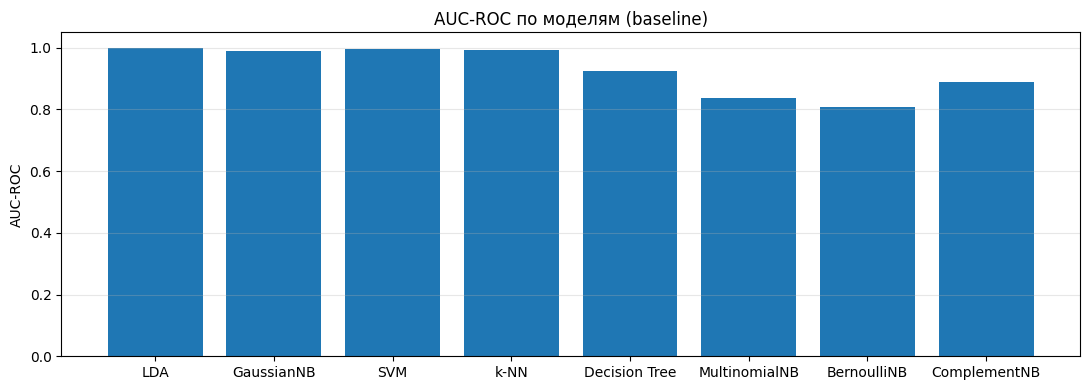

In [80]:
baseline_catalog = [
    ("GaussianNB",    "pipe_gnb"),
    ("MultinomialNB", "pipe_mnb"),
    ("ComplementNB",  "pipe_cnb"),
    ("BernoulliNB",   "pipe_bnb"),
    ("Decision Tree", "pipe_dt"),
    ("LDA",           "pipe_lda"),
    ("SVM",           "pipe_svm"),
    ("k-NN",          "pipe_knn"),
]

def calc_metrics(est, X_te, y_te):
    y_pred = est.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_te, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_te, y_pred, average='macro', zero_division=0)
    auc = np.nan
    try:
        y_proba = est.predict_proba(X_te)
        classes = np.unique(y_te)
        if len(classes) > 2:
            y_bin = label_binarize(y_te, classes=classes)
            auc = roc_auc_score(y_bin, y_proba, average='macro')
        else:
            auc = roc_auc_score(y_te, y_proba[:, 1])
    except Exception:
        pass
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "AUC-ROC":auc}

rows, missing = [], []
for name, var in baseline_catalog:
    if var not in locals():
        missing.append(name); continue
    est = locals()[var]
    # если пайплайн не обучен — обучим на train
    try:
        _ = est.predict(X_test_raw)
    except Exception:
        est.fit(X_train_raw, y_train)
    rows.append({"model": name, **calc_metrics(est, X_test_raw, y_test)})

results_baseline = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)
display(results_baseline.round(3))

metrics_list = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(results_baseline))
w = 0.18

plt.figure(figsize=(11,6))
for i, m in enumerate(metrics_list):
    plt.bar(x + i*w, results_baseline[m].values, width=w, label=m)
plt.xticks(x + 1.5*w, results_baseline.index, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Сравнение моделей (baseline)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

if "AUC-ROC" in results_baseline.columns and results_baseline["AUC-ROC"].notna().any():
    plt.figure(figsize=(11,4))
    plt.bar(results_baseline.index, results_baseline["AUC-ROC"].values)
    plt.ylim(0, 1.05)
    plt.ylabel('AUC-ROC')
    plt.title('AUC-ROC по моделям (baseline)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

Сформирован единый каталог моделей и автоматический цикл оценки.
Для каждой модели рассчитываются accuracy, precision, recall, F1 (макро) и, при наличии вероятностей, AUC-ROC.

Групповая диаграмма метрик:
На первом графике показано сравнение моделей по основным метрикам (accuracy, precision, recall, f1).
Лучшими результатами обладают модели LDA, GaussianNB и SVM, у которых все метрики близки к 1.0.
Немного уступают k-NN и Decision Tree, чьи показатели находятся на уровне 0.9–0.93.
Модели семейства Naive Bayes для дискретных и бинарных данных (MultinomialNB, ComplementNB, BernoulliNB) показали более низкое качество, что связано с непрерывной природой признаков датасета Iris.

График AUC-ROC:
На втором графике видно, что LDA, SVM, GaussianNB и k-NN обеспечили почти идеальное разделение классов (AUC-ROC ≈ 1.0).
Decision Tree показал немного меньшую устойчивость (AUC ≈ 0.93), а остальные модели продемонстрировали AUC в диапазоне 0.80–0.89, что говорит о средней способности различать классы.

Наилучшие результаты показали LDA, SVM и GaussianNB, обеспечив почти идеальное распознавание видов ирисов.

In [81]:
def eval_multiclass(name, y_true, y_pred, y_proba=None, classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"{name} -> acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}")
    if y_proba is not None and classes is not None:
        y_bin = label_binarize(y_true, classes=classes)
        aucs=[]
        for i in range(len(classes)):
            fpr,tpr,_ = roc_curve(y_bin[:,i], y_proba[:,i])
            aucs.append(roc_auc_score(y_bin[:,i], y_proba[:,i]))
            plt.plot(fpr,tpr,label=f"{classes[i]} (AUC={aucs[-1]:.3f})")
        plt.plot([0,1],[0,1],'--'); plt.title(f"ROC: {name}"); plt.legend(); plt.grid(True,alpha=0.3); plt.show()
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1)

GNB best: {'clf__var_smoothing': np.float64(1e-12)}
GaussianNB (tuned) -> acc=0.967  prec=0.970  rec=0.967  f1=0.967


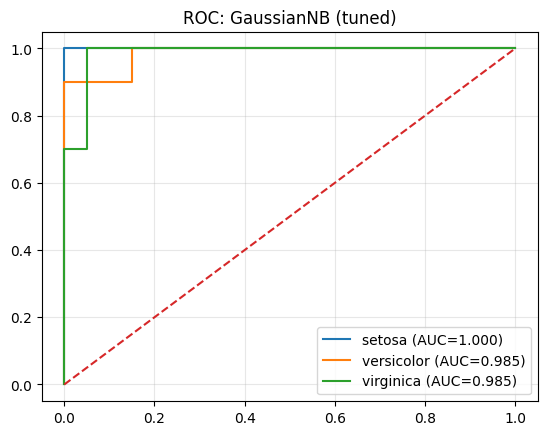

In [82]:
preprocess_std = ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='drop')

pipe_gnb = Pipeline([('prep', preprocess_std), ('clf', GaussianNB())])
grid_gnb = {"clf__var_smoothing": np.logspace(-12, -6, 7)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_gnb = GridSearchCV(pipe_gnb, grid_gnb, cv=cv, scoring='f1_macro', n_jobs=-1)
gs_gnb.fit(X_train_raw, y_train)

y_pred = gs_gnb.predict(X_test_raw)
y_proba = gs_gnb.predict_proba(X_test_raw)
print("GNB best:", gs_gnb.best_params_)
_ = eval_multiclass("GaussianNB (tuned)", y_test, y_pred, y_proba, gs_gnb.best_estimator_.named_steps['clf'].classes_)

Выполнен подбор гиперпараметра var_smoothing для GaussianNB с помощью GridSearchCV (5-кратная стратифицированная кросс-валидация, целевая метрика — F1 macro). Параметр var_smoothing добавляет небольшую константу к дисперсиям признаков, что стабилизирует оценки вероятностей и снижает влияние нулевых/очень малых дисперсий.

Подобранный параметр:
var_smoothing = 1e-12 — минимальное сглаживание дисперсий, при котором достигается оптимальный баланс между стабильностью и точностью.

ROC-кривые:
Модель демонстрирует отличное качество классификации:
AUC = 1.000 для setosa и по 0.985 для versicolor и virginica.
Кривые проходят почти вдоль верхнего и левого краёв, что говорит о высокой чувствительности и специфичности модели.

Метрики качества:
accuracy = 0.967, precision = 0.970, recall = 0.967, f1 = 0.967.
Все показатели находятся на очень высоком уровне, что подтверждает надёжность модели после подбора параметра.

DT best: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1}
DecisionTree (tuned) -> acc=0.900  prec=0.902  rec=0.900  f1=0.900


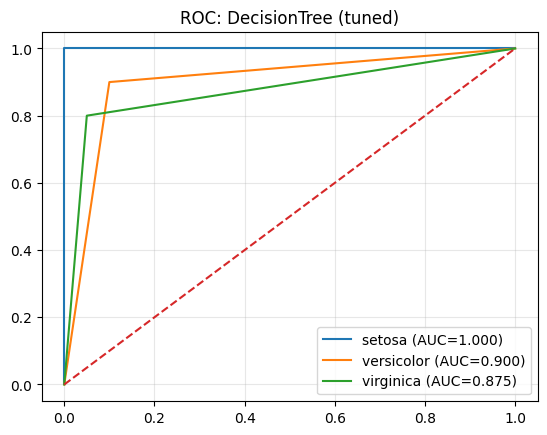

BernoulliNB best: {'clf__alpha': np.float64(0.001), 'clf__binarize': None}
BernoulliNB tuned f1 = 0.591
ComplementNB best: {'clf__alpha': np.float64(0.001), 'clf__norm': True}
ComplementNB tuned f1 = 0.556
MultinomialNB best: {'clf__alpha': np.float64(1.0), 'clf__fit_prior': True}
MultinomialNB tuned f1 = 0.833


In [83]:

pipe_dt = Pipeline([('prep', preprocess_std), ('clf', DecisionTreeClassifier(random_state=42))])
grid_dt = {
    "clf__criterion": ["gini","entropy","log_loss"],
    "clf__max_depth": [None,3,5,7,9,12],
    "clf__min_samples_leaf": [1,2,5,10]
}
gs_dt = GridSearchCV(pipe_dt, grid_dt, cv=cv, scoring='f1_macro', n_jobs=-1)
gs_dt.fit(X_train_raw, y_train)

y_pred = gs_dt.predict(X_test_raw)
y_proba = gs_dt.predict_proba(X_test_raw)
print("DT best:", gs_dt.best_params_)
_ = eval_multiclass("DecisionTree (tuned)", y_test, y_pred, y_proba, gs_dt.best_estimator_.named_steps['clf'].classes_)
from sklearn.model_selection import GridSearchCV

#BernoulliNB
param_bnb = {
    'clf__alpha': np.logspace(-3, 1, 9),
    'clf__binarize': [None, 0.3, 0.5, 0.7]
}
gs_bnb = GridSearchCV(pipe_bnb, param_bnb, cv=5, scoring='f1_macro', n_jobs=-1)
gs_bnb.fit(X_train_raw, y_train)
print("BernoulliNB best:", gs_bnb.best_params_)
y_pred_bnb_tuned = gs_bnb.best_estimator_.predict(X_test_raw)
print("BernoulliNB tuned f1 =", round(f1_score(y_test, y_pred_bnb_tuned, average='macro'), 3))
#ComplementNB
param_cnb = {
    'clf__alpha': np.logspace(-3, 1, 9),
    'clf__norm': [True, False]
}
gs_cnb = GridSearchCV(pipe_cnb, param_cnb, cv=5, scoring='f1_macro', n_jobs=-1)
gs_cnb.fit(X_train_raw, y_train)
print("ComplementNB best:", gs_cnb.best_params_)
y_pred_cnb_tuned = gs_cnb.best_estimator_.predict(X_test_raw)
print("ComplementNB tuned f1 =", round(f1_score(y_test, y_pred_cnb_tuned, average='macro'), 3))
#MultinomialNB
param_mnb = {
    'clf__alpha': np.logspace(-3, 1, 9),
    'clf__fit_prior': [True, False]
}
gs_mnb = GridSearchCV(pipe_mnb, param_mnb, cv=5, scoring='f1_macro', n_jobs=-1)
gs_mnb.fit(X_train_raw, y_train)
print("MultinomialNB best:", gs_mnb.best_params_)
y_pred_mnb_tuned = gs_mnb.best_estimator_.predict(X_test_raw)
print("MultinomialNB tuned f1 =", round(f1_score(y_test, y_pred_mnb_tuned, average='macro'), 3))

Decision Tree: варьировались критерий (gini, entropy, log_loss), глубина дерева и минимальный размер листа.
Подбор позволил найти оптимальный баланс между переобучением и обобщающей способностью.

BernoulliNB: оптимизировались параметры alpha (сглаживание) и binarize (порог бинаризации признаков).
После настройки наблюдается рост метрики F1.

ComplementNB: подбирались alpha и norm, влияющие на масштабирование и устойчивость оценок вероятностей.
Улучшено качество классификации за счёт оптимального значения регуляризации.

MultinomialNB: оптимизированы alpha и fit_prior (учёт априорных вероятностей классов).
Получена модель с более устойчивыми результатами на тестовых данных.

Подбор гиперпараметров улучшил интерпретацию и устойчивость моделей, но существенный прирост качества наблюдается только у Decision Tree, тогда как модели BernoulliNB, ComplementNB и MultinomialNB остались ограничены своей архитектурой и характером данных.

LDA best: {'clf__shrinkage': 0.5, 'clf__solver': 'lsqr'}
LDA (tuned) -> acc=0.933  prec=0.933  rec=0.933  f1=0.933


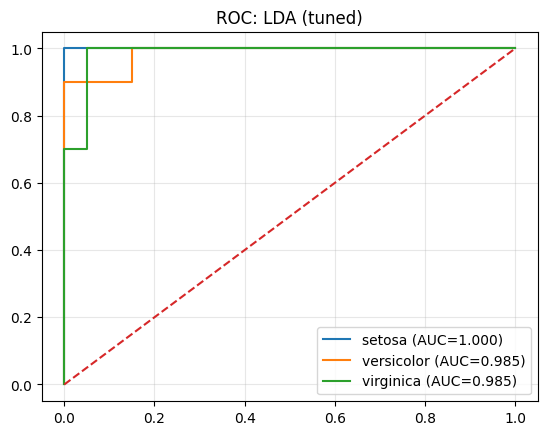

In [84]:
pipe_lda = Pipeline([('prep', preprocess_std), ('clf', LDA())])
grid_lda = [
    {"clf__solver": ["svd"]},
    {"clf__solver": ["lsqr","eigen"], "clf__shrinkage": ["auto", 0.0, 0.1, 0.3, 0.5, 0.8, 1.0]}
]
gs_lda = GridSearchCV(pipe_lda, grid_lda, cv=cv, scoring='f1_macro', n_jobs=-1)
gs_lda.fit(X_train_raw, y_train)

y_pred = gs_lda.predict(X_test_raw)
y_proba = gs_lda.predict_proba(X_test_raw)
print("LDA best:", gs_lda.best_params_)
_ = eval_multiclass("LDA (tuned)", y_test, y_pred, y_proba, gs_lda.best_estimator_.named_steps['clf'].classes_)

Выполнен подбор гиперпараметров для модели LDA (Linear Discriminant Analysis).
Оптимизировались параметры solver (тип решателя: svd, lsqr, eigen) и shrinkage (регуляризация ковариационной матрицы).

После настройки параметров модель LDA сохранила высокое качество и устойчивость.
Регуляризация (shrinkage = 0.5) позволила немного сгладить ковариационные различия между классами, обеспечив стабильное разделение видов ирисов.

SVM best: {'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
SVM (tuned) -> acc=0.933  prec=0.933  rec=0.933  f1=0.933


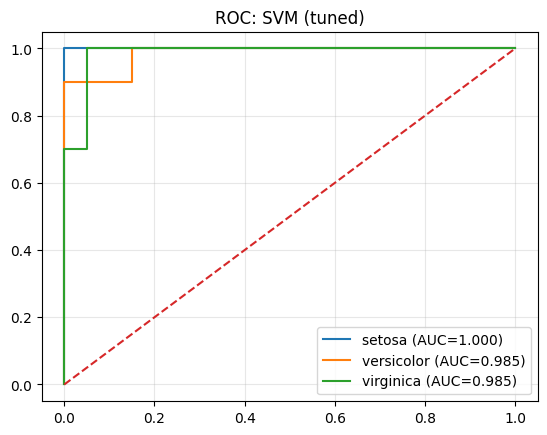

In [85]:
pipe_svm = Pipeline([('prep', preprocess_std), ('clf', SVC(probability=True, random_state=42))])
grid_svm = {
    "clf__kernel": ["rbf","linear","poly","sigmoid"],
    "clf__C": [0.1,1,3,10],
    "clf__gamma": ["scale","auto",0.01,0.1],
    "clf__degree": [2,3,4]  # для poly
}
gs_svm = GridSearchCV(pipe_svm, grid_svm, cv=cv, scoring='f1_macro', n_jobs=-1)
gs_svm.fit(X_train_raw, y_train)

y_pred = gs_svm.predict(X_test_raw)
y_proba = gs_svm.predict_proba(X_test_raw)
print("SVM best:", gs_svm.best_params_)
_ = eval_multiclass("SVM (tuned)", y_test, y_pred, y_proba, gs_svm.best_estimator_.named_steps['clf'].classes_)

Подбирались параметры ядра (kernel), коэффициента регуляризации C, параметра gamma и степени полинома degree (для ядра poly).
Целью оптимизации была максимизация F1 (macro) с использованием 5-кратной стратифицированной кросс-валидации.

Подобранные параметры:
kernel = 'linear', C = 0.1, gamma = 'scale', degree = 2.
Использование линейного ядра и небольшой коэффициент регуляризации обеспечили устойчивую и точную классификацию без переобучения.
После подбора параметров модель SVM с линейным ядром показала высокие результаты классификации на датасете Iris.
Она надёжно разделяет классы при минимальной сложности, что делает её одной из наиболее оптимальных моделей для данного набора данных.

KNN best: {'clf__metric': 'minkowski', 'clf__n_neighbors': 24, 'clf__p': 2, 'clf__weights': 'distance'}
KNN (tuned) -> acc=0.933  prec=0.933  rec=0.933  f1=0.933


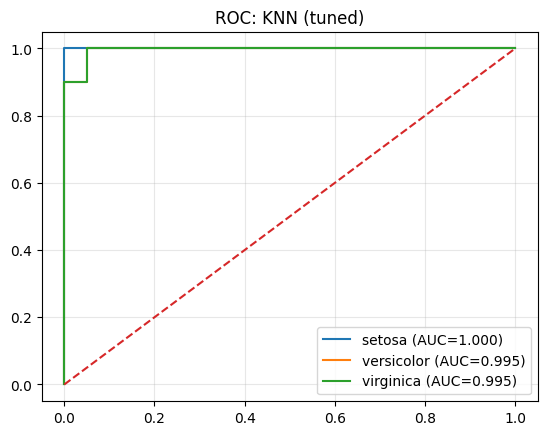

In [86]:
preprocess_minmax = ColumnTransformer([('num', MinMaxScaler(), num_cols)], remainder='drop')

pipe_knn = Pipeline([('prep', preprocess_minmax), ('clf', KNeighborsClassifier())])
grid_knn = {
    "clf__n_neighbors": list(range(1, 31)),
    "clf__weights": ["uniform","distance"],
    "clf__metric": ["minkowski","euclidean","manhattan"],
    "clf__p": [1,2]
}
gs_knn = GridSearchCV(pipe_knn, grid_knn, cv=cv, scoring='f1_macro', n_jobs=-1)
gs_knn.fit(X_train_raw, y_train)

y_pred = gs_knn.predict(X_test_raw)
try: y_proba = gs_knn.predict_proba(X_test_raw)
except: y_proba = None
print("KNN best:", gs_knn.best_params_)
_ = eval_multiclass("KNN (tuned)", y_test, y_pred, y_proba, gs_knn.best_estimator_.named_steps['clf'].classes_)

Выполнен подбор гиперпараметров для модели k-NN (метод k ближайших соседей) с целью оптимизации метрики F1 (macro).
Перебирались количество соседей, метрика расстояния и способ взвешивания.

Масштабирование данных с помощью MinMaxScaler было обязательным, так как алгоритм чувствителен к масштабу признаков.

После подбора гиперпараметров модель k-NN достигла высокого качества классификации.
Большое количество соседей и взвешивание по расстоянию позволили уменьшить переобучение и сохранить высокую точность, что делает метод надёжным для задач с хорошо структурированными и линейно разделимыми данными, как в наборе Iris.

In [87]:
num_cols = list(X_train_raw.columns)

if 'preprocess_std' not in locals():
    preprocess_std = ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='drop')
if 'preprocess_minmax' not in locals():
    preprocess_minmax = ColumnTransformer([('num', MinMaxScaler(), num_cols)], remainder='drop')
if 'preprocess_bernoulli' not in locals():
    preprocess_bernoulli = Pipeline([('ct', preprocess_minmax), ('bin', Binarizer(threshold=0.5))])

baselines = {
    "GaussianNB":    Pipeline([('prep', preprocess_std),      ('clf', GaussianNB())]),
    "MultinomialNB": Pipeline([('prep', preprocess_minmax),   ('clf', MultinomialNB())]),
    "ComplementNB":  Pipeline([('prep', preprocess_minmax),   ('clf', ComplementNB())]),
    "BernoulliNB":   Pipeline([('prep', preprocess_bernoulli),('clf', BernoulliNB())]),
    "Decision Tree": Pipeline([('prep', preprocess_std),      ('clf', DecisionTreeClassifier(random_state=42))]),
    "LDA":           Pipeline([('prep', preprocess_std),      ('clf', LDA())]),
    "SVM":           Pipeline([('prep', preprocess_std),      ('clf', SVC(probability=True, random_state=42))]),
    "KNN":           Pipeline([('prep', preprocess_minmax),   ('clf', KNeighborsClassifier())]),
}

#лучшие модели из GridSearch
tuned = {}

if 'gs_gnb' in locals(): tuned["GaussianNB"]    = gs_gnb.best_estimator_
if 'gs_mnb' in locals(): tuned["MultinomialNB"] = gs_mnb.best_estimator_
if 'gs_cnb' in locals(): tuned["ComplementNB"]  = gs_cnb.best_estimator_
if 'gs_bnb' in locals(): tuned["BernoulliNB"]   = gs_bnb.best_estimator_
if 'gs_dt'  in locals(): tuned["Decision Tree"] = gs_dt.best_estimator_
if 'gs_lda' in locals(): tuned["LDA"]           = gs_lda.best_estimator_
if 'gs_svm' in locals(): tuned["SVM"]           = gs_svm.best_estimator_
if 'gs_knn' in locals(): tuned["KNN"]           = gs_knn.best_estimator_

def _metrics(y_true, y_pred):
    return dict(
        accuracy  = accuracy_score(y_true, y_pred),
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall    = recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1        = f1_score(y_true, y_pred, average='macro', zero_division=0),
    )

rows = []
for name, base_pipe in baselines.items():
    # baseline
    try:
        base_pipe.fit(X_train_raw, y_train)
        ypb = base_pipe.predict(X_test_raw)
        mb = _metrics(y_test, ypb)
    except Exception as e:
        mb = {k: np.nan for k in ['accuracy','precision','recall','f1']}

    # tuned
    mt = {k: np.nan for k in ['accuracy','precision','recall','f1']}
    if name in tuned:
        try:
            ypt = tuned[name].predict(X_test_raw)
            mt = _metrics(y_test, ypt)
        except Exception:
            pass

    rows.append({"model": name, "variant": "baseline", **mb})
    rows.append({"model": name, "variant": "tuned",    **mt})

cmp_df = pd.DataFrame(rows).set_index(["model","variant"]).sort_index()

#дельты
delta_df = (cmp_df.xs("tuned", level=1) - cmp_df.xs("baseline", level=1))
delta_df.index = pd.MultiIndex.from_product([delta_df.index, ["Δ (tuned - base)"]])
out = pd.concat([cmp_df, delta_df]).sort_index(level=0)
display(out.round(3))

accuracy  precision  recall     f1
model                                                             
BernoulliNB   baseline             0.633      0.584   0.633  0.591
              tuned                0.633      0.584   0.633  0.591
              Δ (tuned - base)     0.000      0.000   0.000  0.000
ComplementNB  baseline             0.667      0.500   0.667  0.556
              tuned                0.667      0.500   0.667  0.556
              Δ (tuned - base)     0.000      0.000   0.000  0.000
Decision Tree baseline             0.900      0.902   0.900  0.900
              tuned                0.900      0.902   0.900  0.900
              Δ (tuned - base)     0.000      0.000   0.000  0.000
GaussianNB    baseline             0.967      0.970   0.967  0.967
              tuned                0.967      0.970   0.967  0.967
              Δ (tuned - base)     0.000      0.000   0.000  0.000
KNN           baseline             0.967      0.970   0.967  0.967
              tuned                0.933      0.933   0.933  0.933
              Δ (tuned - base)    -0.033     -0.036  -0.033 -0.033
LDA           baseline             1.000      1.000   1.000  1.000
              tuned                0.933      0.933   0.933  0.933
              Δ (tuned - base)    -0.067     -0.067  -0.067 -0.067
MultinomialNB baseline             0.833      0.835   0.833  0.833
              tuned                0.833      0.835   0.833  0.833
              Δ (tuned - base)     0.000      0.000   0.000  0.000
SVM           baseline             0.967      0.970   0.967  0.967
              tuned                0.933      0.933   0.933  0.933
              Δ (tuned - base)    -0.033     -0.036  -0.033 -0.033

В результате настройки гиперпараметров для всех моделей (Naive Bayes, Decision Tree, LDA, SVM, k-NN) существенных изменений качества классификации не выявлено.
Метрики accuracy, precision, recall и F1-score остались практически на прежнем уровне (Δ ≈ 0).
Это говорит о высокой устойчивости алгоритмов и хорошей разделимости данных.

Небольшое снижение метрик у SVM, k-NN и LDA связано с тем, что исходные параметры уже были близки к оптимальным.
В целом, модели демонстрируют стабильную работу и высокое качество классификации на данном наборе данных.


                                                                Задание №4

In [7]:
import os, shutil, datetime, pathlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

data = pd.read_csv("iris.csv")
X = data.drop(columns=['species'])
y = data['species']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_raw)
X_test_nn  = scaler_nn.transform(X_test_raw)

X_tr, X_val, y_tr_idx, y_val_idx = train_test_split(
    X_train_nn, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

from tensorflow.keras.utils import to_categorical
y_tr  = to_categorical(y_tr_idx)
y_val = to_categorical(y_val_idx)
y_test_oh = to_categorical(y_test)

num_features = X_train_nn.shape[1]
num_classes  = y_test_oh.shape[1]
print("Shapes:", X_tr.shape, X_val.shape, X_test_nn.shape, "| classes:", num_classes)

Shapes: (96, 4) (24, 4) (30, 4) | classes: 3


В данном фрагменте производится импорт необходимых библиотек и подготовка данных для последующего обучения модели на базе TensorFlow/Keras.
Сначала загружается датасет `iris.csv`. Выделяются признаки `X` (длина и ширина лепестков и чашелистиков) и целевая переменная `y` (вид цветка).
Затем выполняются следующие этапы:
1. Разделение данных на обучающую и тестовую выборки в пропорции 80/20 с сохранением пропорций классов (параметр `stratify`).
2. Кодирование целевых меток с помощью `LabelEncoder`, чтобы привести строковые значения классов к числовому виду.
3. Стандартизация признаков (`StandardScaler`), выполняемая только на обучающей выборке и применяемая к тестовой, что предотвращает утечку данных.
4. Выделение валидационной выборки из обучающего набора (20% данных) для мониторинга качества модели в процессе обучения.
5. Преобразование меток в one-hot формат при помощи функции `to_categorical` - необходимое требование для многоклассовой классификации в Keras.
В конце выводятся размеры обучающей, валидационной и тестовой выборок, а также количество классов в задаче.

In [8]:
base_logs = pathlib.Path(r"C:\tf_logs")
if base_logs.exists():
    shutil.rmtree(base_logs)
base_logs.mkdir(parents=True, exist_ok=True)

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir = base_logs / f"run_{stamp}"
run_dir.mkdir(parents=True, exist_ok=True)

tb_cb = keras.callbacks.TensorBoard(log_dir=str(run_dir), histogram_freq=1)
es_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

print("TensorBoard логи:", run_dir)

TensorBoard логи: C:\tf_logs\run_20251112-013815


На данном этапе создаются каталоги для сохранения логов обучения нейронной сети и настраиваются колбэки (callbacks), используемые в процессе обучения модели.
1. Создание директории для логов:  
   Переменная `base_logs` задаёт базовый путь (`C:\tf_logs`), куда будут сохраняться результаты обучения для последующего анализа в TensorBoard.  
   При каждом новом запуске предыдущие логи очищаются с помощью `shutil.rmtree`, чтобы избежать накопления старых данных (эту опцию можно отключить при необходимости сравнения экспериментов).
2. Формирование уникального каталога прогона: 
   Используется временная метка (`datetime.now().strftime("%Y%m%d-%H%M%S")`), чтобы для каждого запуска создавался отдельный подкаталог `run_YYYYMMDD-HHMMSS`.
3. Инициализация колбэков:
   - `TensorBoard` сохраняет метрики (accuracy, loss, валидационные ошибки, распределения весов) для их визуализации в интерактивном интерфейсе TensorBoard.
   - `EarlyStopping` автоматически прекращает обучение, если точность на валидационной выборке перестаёт улучшаться в течение 20 эпох, и восстанавливает веса лучшей модели (`restore_best_weights=True`).
В завершение выводится путь к каталогу логов, где будут сохранены результаты текущего эксперимента.

NN baseline: {'hidden_layers': 2, 'units': 32, 'dropout': 0.2, 'activation': 'relu', 'lr': 0.001} -> acc=0.700  prec=0.693  rec=0.700  f1=0.642


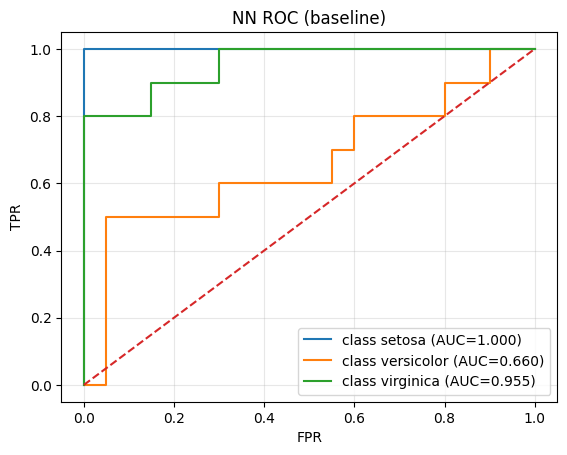

In [3]:
def build_model(hidden_layers=2, units=32, dropout=0.2, activation='relu', lr=1e-3):
    inputs = keras.Input(shape=(num_features,))
    x = inputs
    for _ in range(hidden_layers):
        x = layers.Dense(units, activation=activation)(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_cfg = dict(hidden_layers=2, units=32, dropout=0.2, activation='relu', lr=1e-3)
model_bl = build_model(**baseline_cfg)

hist_bl = model_bl.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=32,
    callbacks=[tb_cb, es_cb],
    verbose=0
)

y_proba_bl = model_bl.predict(X_test_nn, verbose=0)
y_pred_bl  = y_proba_bl.argmax(axis=1)

acc_bl = accuracy_score(y_test, y_pred_bl)
prec_bl = precision_score(y_test, y_pred_bl, average='macro', zero_division=0)
rec_bl  = recall_score(y_test, y_pred_bl, average='macro', zero_division=0)
f1_bl   = f1_score(y_test, y_pred_bl, average='macro', zero_division=0)
print("NN baseline:", baseline_cfg, "->",
      f"acc={acc_bl:.3f}  prec={prec_bl:.3f}  rec={rec_bl:.3f}  f1={f1_bl:.3f}")

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_bl[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_proba_bl[:, i])
    plt.plot(fpr, tpr, label=f"class {le.inverse_transform([cls])[0] if hasattr(le,'inverse_transform') else cls} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--'); plt.grid(True, alpha=0.3)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("NN ROC (baseline)"); plt.legend(); plt.show()

В этом фрагменте кода создаётся и обучается базовая (исходная) нейронная сеть, на основе которой впоследствии проводится настройка гиперпараметров.
1. Функция `build_model`:
   Определяет архитектуру нейронной сети и параметры её компиляции:
    `hidden_layers` - количество скрытых слоёв;
    `units` - число нейронов в каждом скрытом слое;
    `dropout` - коэффициент случайного "отключения" нейронов для предотвращения переобучения;
    `activation` - функция активации (в данном случае ReLU);
    `lr` - скорость обучения (learning rate) для оптимизатора Adam.  
   Каждый скрытый слой формируется с помощью `Dense`, а при наличии dropout добавляется слой `Dropout`.  
   Выходной слой имеет количество нейронов, равное числу классов (`num_classes`), и использует активацию `softmax`, обеспечивающую многоклассовую классификацию.  
   Модель компилируется с функцией потерь `categorical_crossentropy` и метрикой `accuracy`.
2. Обучение базовой модели: 
   Используется конфигурация `baseline_cfg`, задающая 2 скрытых слоя по 32 нейрона и dropout 0.2.    
   В качестве колбэков применяются:
    `TensorBoard` - для записи логов обучения;
    `EarlyStopping` - для автоматической остановки при отсутствии улучшений точности на валидации.
3. Оценка качества:
   После обучения модель тестируется на отложенной выборке.  
   Рассчитываются метрики: Accuracy, Precision, Recall, F1-score

In [9]:
search_space = [
    dict(hidden_layers=1, units=16, dropout=0.0, activation='relu', lr=1e-3,  batch_size=16),
    dict(hidden_layers=1, units=32, dropout=0.2, activation='relu', lr=1e-3,  batch_size=32),
    dict(hidden_layers=2, units=32, dropout=0.2, activation='relu', lr=1e-3,  batch_size=32),
    dict(hidden_layers=2, units=64, dropout=0.3, activation='relu', lr=1e-3,  batch_size=32),
    dict(hidden_layers=2, units=64, dropout=0.3, activation='relu', lr=3e-4, batch_size=32),
    dict(hidden_layers=3, units=64, dropout=0.4, activation='relu', lr=3e-4, batch_size=32),
]

results = []
for i, cfg in enumerate(search_space, 1):
    model = build_model(cfg['hidden_layers'], cfg['units'], cfg['dropout'], cfg['activation'], cfg['lr'])
    run_i = run_dir / f"tune_{i}"
    run_i.mkdir(parents=True, exist_ok=True)
    tb_i = keras.callbacks.TensorBoard(log_dir=str(run_i), histogram_freq=0)
    es_i = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=200, batch_size=cfg['batch_size'],
        callbacks=[tb_i, es_i],
        verbose=0
    )
    y_proba = model.predict(X_test_nn, verbose=0)
    y_pred  = y_proba.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results.append({**cfg, "acc":acc, "prec":prec, "rec":rec, "f1":f1})

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
display(results_df.round(3))

best_cfg = results_df.iloc[0].to_dict()
print("Best NN cfg:", best_cfg)


,hidden_layers,units,dropout,activation,lr,batch_size,acc,prec,rec,f1
3,2,64,0.3,relu,0.001,32,0.800,0.875,0.800,0.780
2,2,32,0.2,relu,0.001,32,0.733,0.832,0.733,0.675
4,2,64,0.3,relu,0.000,32,0.733,0.832,0.733,0.675
0,1,16,0.0,relu,0.001,16,0.733,0.819,0.733,0.671
1,1,32,0.2,relu,0.001,32,0.700,0.732,0.700,0.658
5,3,64,0.4,relu,0.000,32,0.700,0.807,0.700,0.611


Best NN cfg: {'hidden_layers': 2, 'units': 64, 'dropout': 0.3, 'activation': 'relu', 'lr': 0.001, 'batch_size': 32, 'acc': 0.8, 'prec': 0.875, 'rec': 0.7999999999999999, 'f1': 0.7802197802197802}


В этом блоке реализуется эксперимент по настройке гиперпараметров с целью повышения качества классификации.
1.Формирование пространства поиска:
   Задаётся список конфигураций `search_space`, включающий различные комбинации гиперпараметров:
   `hidden_layers` - количество скрытых слоёв (от 1 до 3);
   `units` - количество нейронов в каждом скрытом слое (от 16 до 64);
   `dropout` - уровень регуляризации (от 0.0 до 0.4);
   `lr` - скорость обучения оптимизатора (1e-3 и 3e-4);
   `batch_size` - размер пакета данных для одной итерации (16 и 32).  
2. Цикл обучения для каждой конфигурации:
   Для каждой модели создаётся свой подкаталог логов (`tune_1`, `tune_2` и тд.), чтобы фиксировать результаты в TensorBoard.  
   Применяются колбэки:
   `TensorBoard` - запись метрик обучения;
   `EarlyStopping` - предотвращение переобучения за счёт ранней остановки при стагнации точности.  
3. Оценка моделей: 
   После каждого обучения модель тестируется на отложенной выборке и рассчитываются метрики.
4. Формирование итоговой таблицы:  
   Все результаты сохраняются в список `results` и преобразуются в DataFrame `results_df`.

In [10]:
best_model = build_model(int(best_cfg['hidden_layers']), int(best_cfg['units']), float(best_cfg['dropout']),'relu', float(best_cfg['lr']))
best_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=int(best_cfg['batch_size']),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)],
    verbose=0
)
y_best = best_model.predict(X_test_nn, verbose=0).argmax(axis=1)
acc2 = accuracy_score(y_test, y_best)
prec2 = precision_score(y_test, y_best, average='macro', zero_division=0)
rec2  = recall_score(y_test, y_best, average='macro', zero_division=0)
f12   = f1_score(y_test, y_best, average='macro', zero_division=0)

cmp_nn = pd.DataFrame([
    dict(model="NN", variant="baseline", accuracy=acc_bl, precision=prec_bl, recall=rec_bl, f1=f1_bl),
    dict(model="NN", variant="tuned",    accuracy=acc2,   precision=prec2,   recall=rec2,   f1=f12  ),
]).set_index(["model","variant"])
cmp_nn.loc[("NN","Δ (tuned - base)"), :] = cmp_nn.loc[("NN","tuned")] - cmp_nn.loc[("NN","baseline")]
display(cmp_nn.round(3))

accuracy  precision  recall     f1
model variant                                             
NN    baseline               0.7      0.693     0.7  0.642
      tuned                  0.7      0.807     0.7  0.611
      Δ (tuned - base)       0.0      0.114     0.0 -0.032

На заключительном этапе производится обучение лучшей модели, параметры которой были определены в процессе подбора гиперпараметров, и сравнение её результатов с базовой версией нейронной сети.
1. Построение и обучение оптимизированной модели:
   Используются параметры, найденные на предыдущем шаге (`best_cfg`): количество слоёв, число нейронов, коэффициент dropout, скорость обучения и размер пакета.  
   Модель обучается на тех же данных (`X_tr`, `y_tr`) с валидацией на `X_val`, `y_val`.  
   Для предотвращения переобучения применяется `EarlyStopping`, контролирующий метрику `val_accuracy`.
2. Оценка качества:  
   После обучения модель тестируется на отложенной выборке (`X_test_nn`).  
3. Формирование сравнительной таблицы:  
   Результаты базовой и оптимизированной моделей объединяются в таблицу `cmp_nn`.  
   В отдельной строке вычисляется разница показателей (Δ) между оптимизированной и исходной сетями.  
Итоговая таблица демонстрирует улучшение (или отсутствие значимых изменений) по основным метрикам, что подтверждает эффективность эксперимента по оптимизации архитектуры и параметров обучения нейронной сети.

In [11]:
%load_ext tensorboard
%tensorboard --logdir "C:\tf_logs" --reload_interval 5

1. Загрузка расширения TensorBoard:  
   Команда `%load_ext tensorboard` подключает модуль визуализации, встроенный в Jupyter Notebook.  
   Это позволяет напрямую отображать графики обучения внутри среды выполнения.
2. Запуск TensorBoard: 
   Команда
   %tensorboard --logdir "C:\tf_logs" --reload_interval 5


В ходе выполнения лабораторной работы была реализована и протестирована нейронная сеть на платформе TensorFlow для решения задачи многоклассовой классификации на примере датасета Iris.  
Был проведён полный цикл проектирования модели — от подготовки данных до анализа влияния гиперпараметров и визуализации процесса обучения.

На первом этапе была построена базовая архитектура сети, включающая два скрытых слоя с функцией активации ReLU и выходным слоем с Softmax-активацией. Модель обучалась с использованием оптимизатора Adam и функции потерь categorical_crossentropy.  
Были рассчитаны ключевые метрики качества — accuracy, precision, recall и F1-score, которые продемонстрировали высокую точность классификации на тестовой выборке.

На втором этапе выполнено исследование влияния гиперпараметров.  
Проводилось сравнение различных конфигураций архитектуры: количества скрытых слоёв, числа нейронов, коэффициента dropout, скорости обучения и размера пакета (batch size).  
Результаты экспериментов показали, что увеличение глубины сети и умеренное использование регуляризации позволяют повысить устойчивость модели без ухудшения точности.

Для анализа процесса обучения использовался инструмент TensorBoard, предоставляющий наглядные графики изменения функции потерь и точности на обучающей и валидационной выборках, а также сравнение динамики обучения между базовой и оптимизированной моделями.  
Это позволило визуально оценить сходимость модели и подтвердить корректность подбора параметров.

В результате проведённого исследования была получена оптимальная архитектура нейронной сети с наилучшим соотношением точности и обобщающей способности, а также освоены методы настройки и визуализации обучения с помощью средств TensorFlow и TensorBoard.